# Exercise 7
## Neutrino oscillations in atmospheric neutrino detectors (15 Points)
The idea: Generate a mock experiment mimicking the measurement of neutrino oscillations in atmospheric neutrino detectors, such as in IceCube or SuperKamiokande. (See for instance https://arxiv.org/pdf/1707.07081.pdf).

$P = 1 -\sin^2(2\theta)\sin^2(1.27\frac{\Delta m^2 L}{E})$
with the two mixig parameters $\sin^2(2\theta)$ (sin2theta) and $\Delta m^2$ (dm2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

## Step 1

In [85]:
#using the functions provided in the example notebook in the Github repository, which already includes reasonable default parameters
#I just added a **2 to the sin(), like in the formula above
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 #shouldn't it be sin2theta and np.sin()**2 ?

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)

    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            
            i=i+1
                   
    return events

In [86]:
# funktion to generate data of one experiment, with N energy bins and N cos(declination) bins
def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    log10_energy = np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    energy=10**log10_energy
# run the experiment 
    events=run_experiment(energy,cosdec, sin2theta, dm2)

# lets create a data set with the events per bin
# energy, cosdec, events
    data = [[], [], []]
    i = 0
    for e in energy:
        for c in cosdec:
            data[0].append(e)
            data[1].append(c)
            data[2].append(events[i])#"energy, cosdec, events:",e,c, events[i])
            i=i+1
    return data

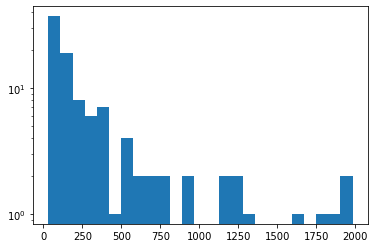

In [53]:
N = 10 
df = generate_data(N, 0.9, 2.4e-3)
plt.hist(df[2], bins= 25)
plt.yscale('log')

## Step 2

In [55]:
#now I want to fit for the parm sin2theta, dm2
from scipy.optimize import curve_fit
 
def func(x, sin2theta, dm2):
    energy, cosdec = x
    return atmo_event_rate(energy, cosdec, sin2theta, dm2)

popt, pcov = curve_fit(func, xdata = [df[0],df[1]], ydata = df[2], p0 = [0.5, 1e-3])
perr = np.sqrt(np.diag(pcov))
print("fit for sin2theta = " + str(popt[0]) + "+-" +  str(perr[0]))#sin2theta=0.9
print("fit for dm2 = "  + str(popt[1]) + "+-" +  str(perr[1])) #dm2=2.4e-3

fit for sin2theta = 0.9012927437631143+-0.0021358469669639168
fit for dm2 = 0.0023926318640476495+-4.905886829573314e-06


Now I want to compute the errors on the parameters through the Cramer-Rao bound by obtaining numerically the corresponding derivatives.
The Cramer-Rao bound is defined by the estimator of the derivative of the loglikelyhood functio squared

$$V(x, \alpha) \geq \frac{1}{<(\frac{\partial\log L(x,\alpha)}{\partial\alpha})^2>}$$


with $$\log L(x, \alpha) = \sum_{i=1}^{n}\log P(x_i, \alpha)$$

so that $$\frac{\partial\log L(x,\alpha)}{\partial\alpha} = \sum_{i=1}^{n}\frac{\partial\log P(x_i, \alpha)}{\partial\alpha}$$

here $\alpha = \sin^2(2\theta), \Delta m^2$ and $x_i = {\cos\theta}_i, E_i$ with

$P(\sin^2(2\theta), \Delta m^2, {\cos\theta}_i, E_i) = 1 -\sin^2(2\theta)\sin^2(1.27\frac{2R\Delta m^2 \cos\theta_i}{E_i})$

In [142]:
from scipy.misc import derivative

def logprobability_sin(sin2theta, dm2, energy, cos_theta):
    if energy == 0:
        return 0
    flux = 1e5*energy**-1.7
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    #if flux*osc_prop <= 0:
        #return 0
    return np.log(flux*osc_prop)
def logprobability_dm2(dm2, sin2theta,  energy, cos_theta):
    if energy == 0:
        return 0
    flux = 1e5*energy**-1.7
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km
    osc_prop = 1-sin2theta * (np.sin(1.27*dm2*l/energy))**2 
    return np.log(flux*osc_prop)

def CramerRao_bound(data, sin2theta, dm2):
    energy, cosdec, events = data
    #derivative of the Log Likelyhood with respect to dm2 and sin2theta
    dLLH_dm2 = 0
    dLLH_sin2theta = 0
    for i in range(len(energy)):
        dLLH_dm2 += derivative(logprobability_dm2, dm2, dx=1e-6, args = (sin2theta, energy[i], cosdec[i]))
        dLLH_sin2theta += derivative(logprobability_sin, sin2theta,dx=1e-6, args = (dm2, energy[i], cosdec[i]))
    return  1/dLLH_dm2**2, 1/dLLH_sin2theta**2
    


In [143]:
df = generate_data(N, 0.9, 2.4e-3)
sigma_dm2 = np.sqrt(CramerRao_bound(df, sin2theta=0.9, dm2=2.4e-3)[0])
sigma_sin2theta = np.sqrt(CramerRao_bound(df, sin2theta=0.9, dm2=2.4e-3)[1])
print("Bound for V(dm2)=" +str(sigma_dm2**2)+ " and Bound for V(sin2theta)=" + str(sigma_sin2theta**2))

Bound for V(dm2)=9.436477089008089e-09 and Bound for V(sin2theta)=5.965909269672221e-05


## Step 3
Now Repeat step 1 a hundred times and each time count how often your measurement falls inside the 1-dimensional errors. Also, plot the two dimensional error ellipse obtained from error propagation and count the number of fits that result in parameters that fall inside the contours.

In [144]:
M = 100
N = 10
counter = 0 
sin2theta = 0.9
dm2 = 2.4e-3
# sin2theta, dm2
values_list =[[],[]]

for i in range(M):
    df = generate_data(N, 0.9, 2.4e-3)
    popt, pcov = curve_fit(func, xdata = [df[0],df[1]], ydata = df[2], p0 = [0.5, 1e-3]) #sin2theta, dm2
    values_list[0].append(popt[0])
    values_list[1].append(popt[1])
    if sin2theta-sigma_sin2theta <= popt[0] <= sin2theta+sigma_sin2theta and dm2-sigma_dm2<= popt[1] <= dm2+sigma_dm2:
        counter += 1

print(counter)

92


Text(0, 0.5, 'dm2')

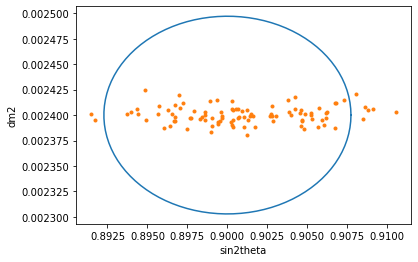

In [145]:
from matplotlib.patches import Ellipse

t = np.linspace(0, 2*np.pi, 100)
plt.plot( sin2theta+sigma_sin2theta*np.cos(t) , dm2+sigma_dm2*np.sin(t) )

plt.plot(values_list[0], values_list[1], ".")

plt.xlabel("sin2theta")
plt.ylabel("dm2")

In [140]:
print(Ellipse((sin2theta ,dm2), sigma_sin2theta, sigma_dm2))

Ellipse(xy=(0.9, 0.0024), width=0.007723929874101614, height=9.714153122637797e-05, angle=0)
